### 基于逻辑斯蒂回归模型的神经网络


In [2]:
import numpy as np
from numpy import linalg
from scipy.special import expit


class NeuralWork(object):
    "三层神经网络,批量训练法"

    def __init__(self, input_nodes, output_nodes, learn_rate, hidden_nodes, epochs, shuffle=True, debug=False):
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.learn_rate = learn_rate
        self.hidden_nodes = hidden_nodes
        self.shuffle = shuffle
        self.w1 = None
        self.w2 = None
        self.epochs = epochs
        self.costs = None
        self.debug = debug

    def init_wight(self):
        self.w1 = np.random.normal(loc=0., scale=0.1, size=(self.hidden_nodes, self.input_nodes + 1))
        self.w2 = np.random.normal(loc=0., scale=0.1, size=(self.output_nodes, self.hidden_nodes + 1))

    def add_bais_unit(self, x):
        """
        对X添加偏置
        :param x: np.ndarray
        :return:  np.ndarray
        """
        if x.ndim == 1:
            x_copy = np.r_[1, x]
            return x_copy
        else:
            raise AttributeError('ndim must be 1')

    def forward(self, x, w1, w2):
        """
        前向传播
        :param x: x: array, shape=[input_nodes]
        :return: tupe(array,array,array,array,array)
                 最后一层结果,均包含偏置
        """

        # step1: 计算隐藏层输出结果
        # [hidden_nodes,input_nodes+1] dot [input_nodes+1,]
        # -> [hidden_nodes,]
        a1 = self.add_bais_unit(x)
        z2 = np.dot(w1, a1)
        a2 = self.sigmod(z2)

        # step2: 计算输出层输出结果
        # [output_nodes, hidden_nodes+1] dot [hidden_nodes+1,]
        # -> [output_nodes,]
        a2 = self.add_bais_unit(a2)
        z3 = np.dot(w2, a2)
        a3 = self.sigmod(z3)
        return a1, z2, a2, z3, a3

    def predict(self, X):
        if X.ndim == 1:
            a1, z2, a2, z3, a3 = self.forward(X, self.w1, self.w2)
            return np.argmax(a3)
        else:
            Y = []
            for x in X:
                a1, z2, a2, z3, a3 = self.forward(x, self.w1, self.w2)
                Y.append(np.argmax(a3))
            return np.array(Y)

    def fit(self, X_train, Y_train, X_valid, Y_valid, print_progress=True):

        self.costs = []
        self.init_wight()

        for idx in range(self.epochs):
            if self.shuffle:
                indices = np.arange(X_train.shape[0])
                np.random.shuffle(indices)
                X_train = X_train[indices]
                Y_train = Y_train[indices]
                Y_train_onehot = self.onehots(Y_train)

            cost = 0
            for x, y in zip(X_train, Y_train_onehot):
                a1, z2, a2, z3, a3 = self.forward(x, self.w1, self.w2)
                cost += self.get_cost(a3, y)
                w1_update, w2_update = self.get_gradient(a1, z2, a2, z3, a3, y)

                # check gradient
                if self.debug:
                    gradient_sigma = self.gradient_checked(x, y, w1_update, w2_update)
                    if gradient_sigma <= 1e-7:
                        print('OK: {0}'.format(gradient_sigma))
                    elif gradient_sigma <= 1e-4:
                        print('Warnning: {0}'.format(gradient_sigma))
                    else:
                        print('Error: {0}'.format(gradient_sigma))
                self.w1 -= self.learn_rate * w1_update
                self.w2 -= self.learn_rate * w2_update

            Y_train_pred = self.predict(X_train)
            Y_valid_pred = self.predict(X_valid)
            train_acc = np.sum(Y_train_pred == Y_train) / len(Y_train_pred)
            valid_acc = np.sum(Y_valid_pred == Y_valid) / len(Y_valid_pred)
            if print_progress:
                print('Epoch: {0}/{1} | Costs:{2:.3f} | Train Acc:{3:.3f} | Valid Acc:{4:.3f}'.
                      format(idx + 1, self.epochs, cost / len(Y_train_onehot), train_acc, valid_acc),
                      end='\r')
            self.costs.append(cost / len(Y_train_onehot))

    def get_cost(self, a3, y):
        """
        代价函数
        :param a3: array, shape=[output_nodes,]
        :param y: array, shape[output_nodes,]
        :return: int
                 代价函数
        """
        cost = -y * np.log(a3) - (1. - y) * np.log(1. - a3)
        return cost.sum()

    def get_gradient(self, a1, z2, a2, z3, a3, y):
        """

        :param a1: array, shape=[input_nodes,]
        :param z2: array, shape=[hidden_nodes,]
        :param a2: array, shape=[hidden_nodes+1,]
        :param z3: array
        :param a3: array, shape=[output_nodes,]
        :param y: array, shape=[output_nodes,]
        :return: tuple(array,array)
                 包含偏置项的权重
        """
        # step1: 计算输出层和隐藏层的误差项，包含偏置项
        output_sigma = a3 - y
        # [hidden_nodes+1, output_nodes] dot [output_nodes,]
        # ->[hidden_nodes+1,]
        hidden_sigma = np.dot(self.w2.T, output_sigma)

        # step2：计算隐藏和输入层代价函数梯度
        # [output_nodes,1] dot [1,hidden_nodes+1]
        # -> [output_nodes,hidden_nodes+1]
        hidden_sigma[1:] = hidden_sigma[1:] * self.sigmod_derivative(z2)
        hidden_grad = np.dot(output_sigma[:, np.newaxis], a2[np.newaxis, :])
        # [hidden_nodes,1] dot [1,input_nodes+1]
        # -> [hidden_nodes,input_nodes+1]
        input_grad = np.dot(hidden_sigma[1:, np.newaxis], a1[np.newaxis, :])

        return input_grad, hidden_grad

    def gradient_checked(self, x, y, input_grad, hidden_grad, ep = 1e-6):
        wight_grad1 = np.zeros(self.w1.shape)
        wight_grad2 = np.zeros(self.w2.shape)
        wight_eps = np.zeros(self.w1.shape)
        # 对w1每一项求偏导
        for i in range(self.w1.shape[0]):
            for j in range(self.w1.shape[1]):
                wight_eps[i,j] = ep
                a1, z2, a2, z3, a3 = self.forward(x, self.w1-wight_eps, self.w2)
                cost1 = self.get_cost(a3, y)
                a1, z2, a2, z3, a3 = self.forward(x, self.w1 + wight_eps, self.w2)
                cost2 = self.get_cost(a3, y)
                wight_grad1[i,j] = (cost2 - cost1) / (2 * ep)
                wight_eps[i,j] = 0.

        # 对w2每一项求偏导
        wight_eps = np.zeros(self.w2.shape)
        for i in range(self.w2.shape[0]):
            for j in range(self.w2.shape[1]):
                wight_eps[i,j] = ep
                a1, z2, a2, z3, a3 = self.forward(x, self.w1, self.w2-wight_eps)
                cost1 = self.get_cost(a3, y)
                a1, z2, a2, z3, a3 = self.forward(x, self.w1, self.w2+wight_eps)
                cost2 = self.get_cost(a3, y)
                wight_grad2[i,j] = (cost2 - cost1) / (2 * ep)
                wight_eps[i,j] = 0.
        # 计算误差
        wight_grad = np.hstack((wight_grad1.flatten(), wight_grad2.flatten()))
        grad = np.hstack((input_grad.flatten(), hidden_grad.flatten()))
        norm1 = linalg.norm(wight_grad - grad)
        norm2 = linalg.norm(wight_grad)
        norm3 = linalg.norm(grad)
        return norm1 / (norm2 + norm3)

    def sigmod(self, x):
        return expit(x)

    @staticmethod
    def onehots(y):
        onehot = np.zeros((len(y), 10))
        for i, x in enumerate(y):
            onehot[i][x] = 1
        return onehot

    def sigmod_derivative(self, x):
        """
        sigmod导函数
        :param x: array or float
        :return: array or float
        """
        return self.sigmod(x) * (1 - self.sigmod(x))

### 读取MNIST数据集

In [4]:
import struct
lables_train = None
images_train = None
lables_test = None
images_test = None
with open('train-labels.idx1-ubyte','rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    lables_train = np.fromfile(lbpath, dtype = np.uint8)

with open('train-images.idx3-ubyte', 'rb') as imgpath:
    magic,num,rows,cols=struct.unpack('>IIII',imgpath.read(16))
    images_train = np.fromfile(imgpath, dtype=np.uint8).reshape(-1, 784)

with open('t10k-labels.idx1-ubyte','rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    lables_test = np.fromfile(lbpath, dtype = np.uint8)

with open('t10k-images.idx3-ubyte', 'rb') as imgpath:
    magic,num,rows,cols=struct.unpack('>IIII',imgpath.read(16))
    images_test = np.fromfile(imgpath, dtype=np.uint8).reshape(-1, 784) 


### 构建模型，训练

In [9]:
nw = NeuralWork(input_nodes=784,
                output_nodes=10,
                learn_rate=0.0001,
                hidden_nodes=50,
                shuffle=True,
                debug=False,
                epochs=1000)
nw.fit(images_train[:55000], lables_train[:55000],
       images_train[55000:], lables_train[55000:])

Epoch: 1/1000 | Costs:2.852 | Train Acc:0.670 | Valid Acc:0.717
Epoch: 2/1000 | Costs:2.008 | Train Acc:0.771 | Valid Acc:0.821
Epoch: 3/1000 | Costs:1.592 | Train Acc:0.817 | Valid Acc:0.862
Epoch: 4/1000 | Costs:1.343 | Train Acc:0.842 | Valid Acc:0.882
Epoch: 5/1000 | Costs:1.182 | Train Acc:0.858 | Valid Acc:0.894
Epoch: 6/1000 | Costs:1.067 | Train Acc:0.867 | Valid Acc:0.903
Epoch: 7/1000 | Costs:0.979 | Train Acc:0.877 | Valid Acc:0.909
Epoch: 8/1000 | Costs:0.911 | Train Acc:0.883 | Valid Acc:0.910
Epoch: 9/1000 | Costs:0.860 | Train Acc:0.887 | Valid Acc:0.913
Epoch: 10/1000 | Costs:0.818 | Train Acc:0.894 | Valid Acc:0.920
Epoch: 11/1000 | Costs:0.783 | Train Acc:0.895 | Valid Acc:0.921
Epoch: 12/1000 | Costs:0.751 | Train Acc:0.896 | Valid Acc:0.922
Epoch: 13/1000 | Costs:0.729 | Train Acc:0.901 | Valid Acc:0.924
Epoch: 14/1000 | Costs:0.708 | Train Acc:0.901 | Valid Acc:0.926
Epoch: 15/1000 | Costs:0.689 | Train Acc:0.908 | Valid Acc:0.929
Epoch: 16/1000 | Costs:0.669 | Tra

Epoch: 127/1000 | Costs:0.339 | Train Acc:0.952 | Valid Acc:0.959
Epoch: 128/1000 | Costs:0.332 | Train Acc:0.953 | Valid Acc:0.958
Epoch: 129/1000 | Costs:0.329 | Train Acc:0.953 | Valid Acc:0.952
Epoch: 130/1000 | Costs:0.330 | Train Acc:0.953 | Valid Acc:0.958
Epoch: 131/1000 | Costs:0.328 | Train Acc:0.954 | Valid Acc:0.957
Epoch: 132/1000 | Costs:0.328 | Train Acc:0.955 | Valid Acc:0.958
Epoch: 133/1000 | Costs:0.324 | Train Acc:0.955 | Valid Acc:0.959
Epoch: 134/1000 | Costs:0.318 | Train Acc:0.955 | Valid Acc:0.956
Epoch: 135/1000 | Costs:0.324 | Train Acc:0.954 | Valid Acc:0.956
Epoch: 136/1000 | Costs:0.325 | Train Acc:0.955 | Valid Acc:0.957
Epoch: 137/1000 | Costs:0.320 | Train Acc:0.955 | Valid Acc:0.956
Epoch: 138/1000 | Costs:0.321 | Train Acc:0.956 | Valid Acc:0.954
Epoch: 139/1000 | Costs:0.323 | Train Acc:0.955 | Valid Acc:0.956
Epoch: 140/1000 | Costs:0.315 | Train Acc:0.956 | Valid Acc:0.958
Epoch: 141/1000 | Costs:0.318 | Train Acc:0.956 | Valid Acc:0.954
Epoch: 142

Epoch: 252/1000 | Costs:0.256 | Train Acc:0.966 | Valid Acc:0.964
Epoch: 253/1000 | Costs:0.257 | Train Acc:0.964 | Valid Acc:0.961
Epoch: 254/1000 | Costs:0.258 | Train Acc:0.967 | Valid Acc:0.966
Epoch: 255/1000 | Costs:0.250 | Train Acc:0.967 | Valid Acc:0.962
Epoch: 256/1000 | Costs:0.250 | Train Acc:0.967 | Valid Acc:0.961
Epoch: 257/1000 | Costs:0.251 | Train Acc:0.965 | Valid Acc:0.960
Epoch: 258/1000 | Costs:0.250 | Train Acc:0.967 | Valid Acc:0.959
Epoch: 259/1000 | Costs:0.250 | Train Acc:0.966 | Valid Acc:0.962
Epoch: 260/1000 | Costs:0.251 | Train Acc:0.966 | Valid Acc:0.963
Epoch: 261/1000 | Costs:0.252 | Train Acc:0.965 | Valid Acc:0.959
Epoch: 262/1000 | Costs:0.246 | Train Acc:0.968 | Valid Acc:0.963
Epoch: 263/1000 | Costs:0.247 | Train Acc:0.966 | Valid Acc:0.963
Epoch: 264/1000 | Costs:0.251 | Train Acc:0.966 | Valid Acc:0.964
Epoch: 265/1000 | Costs:0.248 | Train Acc:0.966 | Valid Acc:0.960
Epoch: 266/1000 | Costs:0.255 | Train Acc:0.965 | Valid Acc:0.960
Epoch: 267

Epoch: 377/1000 | Costs:0.213 | Train Acc:0.973 | Valid Acc:0.962
Epoch: 378/1000 | Costs:0.211 | Train Acc:0.971 | Valid Acc:0.960
Epoch: 379/1000 | Costs:0.212 | Train Acc:0.971 | Valid Acc:0.962
Epoch: 380/1000 | Costs:0.209 | Train Acc:0.973 | Valid Acc:0.960
Epoch: 381/1000 | Costs:0.209 | Train Acc:0.974 | Valid Acc:0.961
Epoch: 382/1000 | Costs:0.211 | Train Acc:0.971 | Valid Acc:0.963
Epoch: 383/1000 | Costs:0.208 | Train Acc:0.972 | Valid Acc:0.964
Epoch: 384/1000 | Costs:0.209 | Train Acc:0.973 | Valid Acc:0.962
Epoch: 385/1000 | Costs:0.210 | Train Acc:0.973 | Valid Acc:0.961
Epoch: 386/1000 | Costs:0.210 | Train Acc:0.973 | Valid Acc:0.961
Epoch: 387/1000 | Costs:0.209 | Train Acc:0.972 | Valid Acc:0.963
Epoch: 388/1000 | Costs:0.211 | Train Acc:0.973 | Valid Acc:0.963
Epoch: 389/1000 | Costs:0.209 | Train Acc:0.973 | Valid Acc:0.963
Epoch: 390/1000 | Costs:0.218 | Train Acc:0.973 | Valid Acc:0.961
Epoch: 391/1000 | Costs:0.210 | Train Acc:0.974 | Valid Acc:0.962
Epoch: 392

Epoch: 502/1000 | Costs:0.181 | Train Acc:0.977 | Valid Acc:0.964
Epoch: 503/1000 | Costs:0.184 | Train Acc:0.977 | Valid Acc:0.963
Epoch: 504/1000 | Costs:0.184 | Train Acc:0.977 | Valid Acc:0.965
Epoch: 505/1000 | Costs:0.181 | Train Acc:0.977 | Valid Acc:0.965
Epoch: 506/1000 | Costs:0.181 | Train Acc:0.976 | Valid Acc:0.966
Epoch: 507/1000 | Costs:0.185 | Train Acc:0.977 | Valid Acc:0.964
Epoch: 508/1000 | Costs:0.185 | Train Acc:0.974 | Valid Acc:0.966
Epoch: 509/1000 | Costs:0.185 | Train Acc:0.976 | Valid Acc:0.963
Epoch: 510/1000 | Costs:0.185 | Train Acc:0.976 | Valid Acc:0.965
Epoch: 511/1000 | Costs:0.186 | Train Acc:0.976 | Valid Acc:0.966
Epoch: 512/1000 | Costs:0.182 | Train Acc:0.978 | Valid Acc:0.968
Epoch: 513/1000 | Costs:0.177 | Train Acc:0.976 | Valid Acc:0.965
Epoch: 514/1000 | Costs:0.182 | Train Acc:0.977 | Valid Acc:0.964
Epoch: 515/1000 | Costs:0.182 | Train Acc:0.976 | Valid Acc:0.965
Epoch: 516/1000 | Costs:0.185 | Train Acc:0.976 | Valid Acc:0.965
Epoch: 517

Epoch: 627/1000 | Costs:0.165 | Train Acc:0.979 | Valid Acc:0.964
Epoch: 628/1000 | Costs:0.166 | Train Acc:0.981 | Valid Acc:0.964
Epoch: 629/1000 | Costs:0.160 | Train Acc:0.980 | Valid Acc:0.965
Epoch: 630/1000 | Costs:0.163 | Train Acc:0.980 | Valid Acc:0.964
Epoch: 631/1000 | Costs:0.157 | Train Acc:0.981 | Valid Acc:0.966
Epoch: 632/1000 | Costs:0.161 | Train Acc:0.979 | Valid Acc:0.966
Epoch: 633/1000 | Costs:0.166 | Train Acc:0.980 | Valid Acc:0.962
Epoch: 634/1000 | Costs:0.163 | Train Acc:0.980 | Valid Acc:0.966
Epoch: 635/1000 | Costs:0.162 | Train Acc:0.981 | Valid Acc:0.965
Epoch: 636/1000 | Costs:0.160 | Train Acc:0.980 | Valid Acc:0.966
Epoch: 637/1000 | Costs:0.166 | Train Acc:0.980 | Valid Acc:0.966
Epoch: 638/1000 | Costs:0.161 | Train Acc:0.980 | Valid Acc:0.965
Epoch: 639/1000 | Costs:0.170 | Train Acc:0.978 | Valid Acc:0.963
Epoch: 640/1000 | Costs:0.171 | Train Acc:0.980 | Valid Acc:0.964
Epoch: 641/1000 | Costs:0.166 | Train Acc:0.981 | Valid Acc:0.963
Epoch: 642

Epoch: 752/1000 | Costs:0.155 | Train Acc:0.981 | Valid Acc:0.966
Epoch: 753/1000 | Costs:0.148 | Train Acc:0.981 | Valid Acc:0.962
Epoch: 754/1000 | Costs:0.154 | Train Acc:0.982 | Valid Acc:0.968
Epoch: 755/1000 | Costs:0.149 | Train Acc:0.981 | Valid Acc:0.965
Epoch: 756/1000 | Costs:0.151 | Train Acc:0.980 | Valid Acc:0.965
Epoch: 757/1000 | Costs:0.159 | Train Acc:0.981 | Valid Acc:0.967
Epoch: 758/1000 | Costs:0.151 | Train Acc:0.981 | Valid Acc:0.966
Epoch: 759/1000 | Costs:0.158 | Train Acc:0.980 | Valid Acc:0.967
Epoch: 760/1000 | Costs:0.153 | Train Acc:0.982 | Valid Acc:0.966
Epoch: 761/1000 | Costs:0.148 | Train Acc:0.982 | Valid Acc:0.964
Epoch: 762/1000 | Costs:0.151 | Train Acc:0.983 | Valid Acc:0.964
Epoch: 763/1000 | Costs:0.144 | Train Acc:0.983 | Valid Acc:0.964
Epoch: 764/1000 | Costs:0.143 | Train Acc:0.983 | Valid Acc:0.964
Epoch: 765/1000 | Costs:0.146 | Train Acc:0.983 | Valid Acc:0.966
Epoch: 766/1000 | Costs:0.147 | Train Acc:0.982 | Valid Acc:0.963
Epoch: 767

Epoch: 877/1000 | Costs:0.133 | Train Acc:0.984 | Valid Acc:0.966
Epoch: 878/1000 | Costs:0.139 | Train Acc:0.985 | Valid Acc:0.966
Epoch: 879/1000 | Costs:0.132 | Train Acc:0.985 | Valid Acc:0.967
Epoch: 880/1000 | Costs:0.132 | Train Acc:0.984 | Valid Acc:0.965
Epoch: 881/1000 | Costs:0.131 | Train Acc:0.984 | Valid Acc:0.966
Epoch: 882/1000 | Costs:0.130 | Train Acc:0.986 | Valid Acc:0.965
Epoch: 883/1000 | Costs:0.134 | Train Acc:0.984 | Valid Acc:0.967
Epoch: 884/1000 | Costs:0.133 | Train Acc:0.985 | Valid Acc:0.964
Epoch: 885/1000 | Costs:0.127 | Train Acc:0.985 | Valid Acc:0.965
Epoch: 886/1000 | Costs:0.132 | Train Acc:0.984 | Valid Acc:0.964
Epoch: 887/1000 | Costs:0.131 | Train Acc:0.986 | Valid Acc:0.966
Epoch: 888/1000 | Costs:0.123 | Train Acc:0.986 | Valid Acc:0.967
Epoch: 889/1000 | Costs:0.129 | Train Acc:0.985 | Valid Acc:0.967
Epoch: 890/1000 | Costs:0.133 | Train Acc:0.985 | Valid Acc:0.966
Epoch: 891/1000 | Costs:0.130 | Train Acc:0.985 | Valid Acc:0.964
Epoch: 892

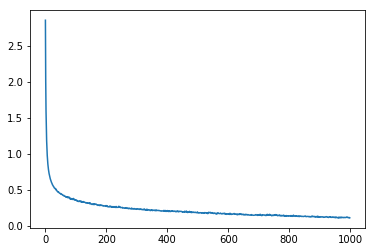

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(nw.costs)
plt.show()